<a href="https://colab.research.google.com/github/timsetsfire/wandb-examples/blob/main/colab/WB101_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weights & Biases 101 🥾🏕️

This notebook is intended to show you how to track your machine learning experiments using [Weights & Biases](https://wandb.ai).

Weights & Biases has two major components: a python client named `wandb` 🪄🐝  and a web application that allows you to store, query, visualize, and share metadata from your machine learning experiments, e.g. loss curves, evaluation metrics, model predictions... you can `wandb.log` *just about* anything.

The client is open source and you can find the [source code on Github](http://github.com/wandb/wandb)! ⭐

The web application is publicly hosted at [wandb.ai](http://wandb.ai), but the app can be deployed in private environments as well. If you're interested in learning more about private deployments of the web app, check out [these docs](http://docs.wandb.ai/guides/self-hosted).

The first step on our journey is to install the client, which is as easy as:

In [2]:
%%capture
!pip install wandb pytorch_lightning keplergl trimesh

In [3]:
import wandb

## Client Configuration

The first thing we do is set the `WANDB_PROJECT` environment variable. This tells the client to send all the data we log to a specific workspace in Weights & Biases. Environment variables are a great way to customize the behavior of the client without having to hardcode contextual details like a project name. You can check out [these docs](https://docs.wandb.ai/guides/track/advanced/environment-variables) for a complete list of the environment variables you can use to configure `wandb`.

In [4]:
import os
os.environ["WANDB_PROJECT"] = "bootcamp"

Next, we need to connect the client to an account in the web server. We do this in a notebook by calling `wandb.login`.

If you have Google SSO enabled for your Weights & Biases account and are running this notebook on colab, the authentication happens automatically when `wandb.login` is called.

Otherwise, you will see a authoriztion link and be asked to enter an API key. If you already have an account, you can follow the authorization link and then copy and paste the displayed API key. If you don't have an account you can sign up with an email address or using a Google or Github account.

In [5]:
import wandb

# Equivalent to running "wandb login" in your shell
#
wandb.login(host="https://api.wandb.ai")
#
# Note that https://api.wandb.ai is the default and points to the publicly hosted
# app. You'll want to change this to a different API endpoint if you are trying
# to connect to a privately hosted server.
#
# Alternative you can configure this with environment variables:
# export WANDB_API_KEY="<your-api-key>"
# export WANDB_BASE_URL="<your-wandb-endpoint>"

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Calling `wandb login` or `wandb.login` will write your API key to your `~/.netrc` file. __To authenticate the client in a headless job on the cloud, you will definitely want to use the `WANDB_API_KEY` environment variable__.

## Track your Experiments

### `wandb.init`

The `wandb.init` function initializes a new `Run`, which you can think of as a comprehensive record of your machine learning experiment. Tracking starts when you call `wandb.init` and ends when you call `wandb.finish` (called automatically via `atexit` hooks if you don't want to invoke manually). You can also use python's `with` statement to initialize and finish runs (see code cell below).

### `wandb.log`

You can call `wandb.log` within your experiment add metrics to your `Run`. The idea is that you will call `wandb.log` many times over an experiment for the same metric, in which case the run saves the whole history of each metric across all of your `wandb.log` calls. The code cell below demonstrates how this looks in a typical stochastic gradient descent loop.




In [6]:
config = dict(
  batch_size=32,
  learning_rate=1e-4,
  flux_capacitors=64,
  life_universe_everything=42,
)

"""
The pattern of "with wandb.init()..." causes wandb.finish() to be called as
soon as we leave the with block. This is especially useful when you have a script
or notebook that initializes multiple runs that you want to track separately.
"""
with wandb.init(config=config):

    for key, value in dict(wandb.config).items():
        print(key, value)

    # Imagine we run 100 epochs of model training
    for x in range(2, 100):

        # Insert model training here...
        # ...

        # Compute metrics (or in this case, make them up)
        metrics = dict(
            loss=(1/x)**0.25,
            accuracy=1-(1/x)*2
        )

        # Pass metrics to Weights & Biases
        wandb.log(metrics)


wandb: Currently logged in as: tim-w. Use `wandb login --relogin` to force relogin


batch_size 32
learning_rate 0.0001
flux_capacitors 64
life_universe_everything 42


accuracy,▁▅▆▇▇▇▇▇▇███████████████████████████████
loss,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9798
loss,0.31702



### Anatomy of a `Run` 🩺

The `Run` stores a detailed record of an experiment within a few specific data structures. The important things to know about are
- `Run.config` is a dictionary like structure that stores configuration data for a run, like the path to input data or training hyperparameters. You can instatiate the config by passing a dictionary to `wandb.init(config=<config-dict>)`.
- `Run.history` is a list of dictionaries that stores historical values of metrics and media over the course of an experiment. We can append a new snapshot of our training metrics by calling `wandb.log(<metric-dict>)`
- `Run.summary` is a dictionary for recording summary metrics or media. By default the `summary` will contain the most recent values logged for each metric, you can overwrite and add elements as you like.


## Log Visualizations

The example we just ran shows you can log numerical metadata over the course of an experiment to Weights & Biases, and we saw how metrics like loss and accuracy show up as customizable line plots in the app. Now let's take a look at some of the other things you can `wandb.log` into your record of an experiment. You can see examples below, but for a first list of loggable types check out [these docs](https://docs.wandb.ai/ref/python/data-types).

### Log Plotly

Plotly is a popular library for building and rendering custom visualizations. It is tightly connected to the ubiquitous `matplotlib` package. We integrate with Plotly so that you can pass `matplotlib` or Plotly figures directly to `wandb.log`, which will automatically serialize and upload your figures to Weights & Biases, where they will be interactively rendered inside of your experiment records. You can run the cells below to see an example logging an interactive, 3D visualization to W&B.

In [7]:
import plotly.express as px

In [8]:
%%wandb

with wandb.init() as run:

  # Loads Iris dataset
  df = px.data.iris()

  # Construct a 3D scatter plot with plotly
  fig = px.scatter_3d(df,
                      x='sepal_length',
                      y='sepal_width',
                      z='petal_width',
                      color='species')

  # Log figure
  run.log({"figure": fig})

### Log Dataframes

You can also log `pandas.DataFrame` objects with `wandb.log`! These will be converted into a `wandb.Table` (docs) and interactievly displayed inside of W&B. The cell below logs the entire Iris dataset and renders it in the W&B app 😎

Note: One of the most powerful features of `wandb.Table`s is that you can include any `wandb` type as a cell value! This includes, images, plots, videos, audio... almost anything 🤩

In [9]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(as_frame=True)
df = data.data
df[data.target.name] = data.target

with wandb.init() as run:
  # Log a pandas Dataframe to Weights & Biases
  wandb.log({"california": df})

### Log HTML

You can use the `wandb.Html` class to pass in any HTML and have it saved and rendered in Weights & Biases. This allows indirect integration with all sorts of visualization libraries, like `keplergl`.

In [10]:
import keplergl
with wandb.init() as run:
  m = keplergl.KeplerGl(height = 400, data = {"data": df})
  m.save_to_html(file_name = "point_map.html")
  run.log({"california housing prices map": wandb.Html(open("point_map.html"))})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to point_map.html!


## Image Masking

In [13]:

import numpy as np
import wandb

with wandb.init() as run:
  image = np.random.randint(low=0, high=256, size=(100, 100, 3), dtype=np.uint8)
  predicted_mask = np.empty((100, 100), dtype=np.uint8)
  ground_truth_mask = np.empty((100, 100), dtype=np.uint8)

  predicted_mask[:50, :50] = 0
  predicted_mask[50:, :50] = 1
  predicted_mask[:50, 50:] = 2
  predicted_mask[50:, 50:] = 3

  ground_truth_mask[:25, :25] = 0
  ground_truth_mask[25:, :25] = 1
  ground_truth_mask[:25, 25:] = 2
  ground_truth_mask[25:, 25:] = 3

  class_labels = {
      0: "person",
      1: "tree",
      2: "car",
      3: "road"
  }

  masked_image = wandb.Image(image, masks={
      "predictions": {
          "mask_data": predicted_mask,
          "class_labels": class_labels
      },
      "ground_truth": {
          "mask_data": ground_truth_mask,
          "class_labels": class_labels
      }
  })
  wandb.log({"img_with_masks" : masked_image})

### Log Sequences of Media

If you periodically `wandb.log` a number (for example, loss), Weights & Biases will automatically render a line plot showing the change in that value over time (a loss curve). You can also log media under a key more than once over the course of an experiment, in which case Weights & Biases will display that media with a step slider so you can scrub over the course of the experiment and see how it changed. This is particularly useful for seeing how model predictions and visualizations of model performance (e.g. a precision/recall curve) change over time. In the example below, we log a `wandb.Image` repeatedly after applying a blur operation between each log step, just to demonstrate how this works.

In [14]:
%%sh
curl https://parade.com/.image/t_share/MTkwNTgwOTUyNjU2Mzg5MjQ1/albert-einstein-quotes-jpg.jpg > image.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  170k  100  170k    0     0   507k      0 --:--:-- --:--:-- --:--:--  506k


In [15]:
%%wandb
from PIL import Image, ImageFilter
import pandas as pd
# Load image with pillow, resize to 512 square
im = Image.open("./image.jpg").resize((512, 512))
images = []
with wandb.init() as run:

  for step in range(15):

    # Log image
    images.append( (step, wandb.Image(im)))
    run.log({"image": wandb.Image(im)})

    # Apply small Gaussian blur
    im = im.filter(ImageFilter.GaussianBlur(radius=1.5))

  wandb.log({ "images_df": pd.DataFrame( images, columns = ["step", "images"])})



# W&B Artifact

Use Weights & Biases Artifacts to track datasets, models, dependencies, and results through each step of your machine learning pipeline. Artifacts make it easy to get a complete and auditable history of changes to your files.
Artifacts can be thought of as a versioned directory. Artifacts are either an input of a run or an output of a run. Common artifacts include entire training sets and models. Store datasets directly into artifacts, or use artifact references to point to data in other systems like Amazon S3, GCP, or your own system.

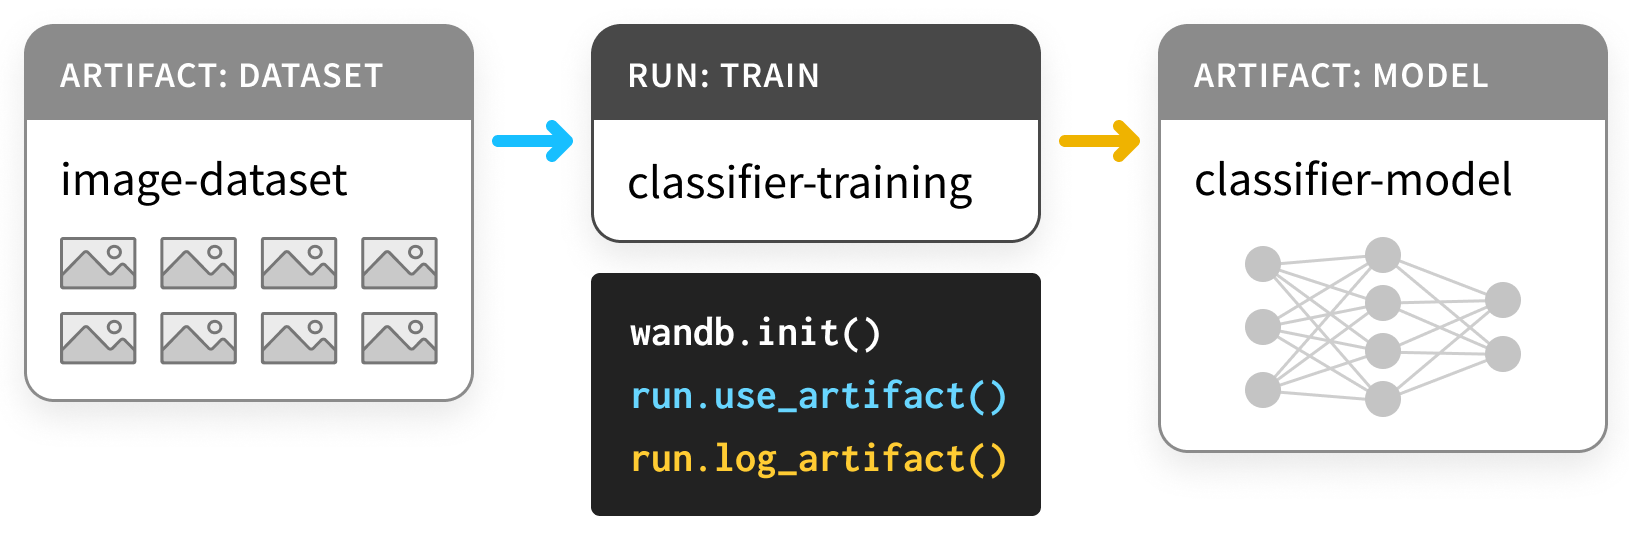

# Getting Started

Logging artifacts to W&B requires an active experiment.  But we can create the Artifact before or during the experiment!  The thing to keep in mind is that we must actually `log_artifact` before the experiment concludes.  

When we start to create an Artifact, we must provide the following
* `name`
* `type`

and we may provide
* `description`
* `metadata`

Usage might look like

```
run = wandb.init(project = "my-project")
artifact = wandb.Artifact(name = "my_artifact", type = "data")
artifact.add_file("/path/to/my/file.txt")
run.log_artifact(artifact)
run.finish()
```

Along with `add_file` we also provide the following methods
* `add_dir` - Adds a local directory to the artifact.
* `add_reference` - Adds a reference denoted by a URI to the artifact. Unlike adding files or directories,
references are NOT uploaded to W&B. However, artifact methods such as `download()` can
be used regardless of whether the artifact contains references or uploaded files.
* `add` - add an W&B object to W&B Artifact.  supported objects include: ImageMasks, Audio, Image, Video, Tables


There are some other patterns of usage that are less common, for example
```
import wandb
artifact = wandb.Artifact(name = "my-data", type = "dataset")
with artifact.new_file("my_data.txt", mode="w") as file:
        file.write("some text")
run = wandb.init("artifact-ex")
run.log_artifact(artifact)
run.finish()
```

In [16]:
with wandb.init() as run:
  artifact = wandb.Artifact(name = "colab-datasets", type = "data")
  artifact.add_dir("/content/sample_data")
  run.log_artifact(artifact)

wandb: Adding directory to artifact (/content/sample_data)... 

{}


Done. 0.4s


# Using Artifacts (and logging Point Clouds)

Using artifacts in an experiment, you will always employ the following pattern

* initialize the run
* use the `run.use_artifact` method

`use_artifact` returns a `wandb.Artifact`.  From here, you will either use the artifact's `get` method or the `download` method

In [ ]:
import wandb
import trimesh
import os
import pandas as pd
create_boxes = lambda x: np.array(  # draw 3d boxes
        [
            {
                "corners": [
                    [10,10,10],
                    [10,10,-10],
                    [-10, 10, 10],
                    [10, -10, 10],
                    [10,-10,-10],
                    [-10, -10, 10],
                    [-10, 10, -10],
                    [-10,-10,-10]
                ],
                "label": "Box-1",
                "color": [123, 321, 111],
            },
            {
                "corners": [
                    [0,0,0],
                    [0,2,0],
                    [0,0,2],
                    [2,0,0],
                    [2,2,0],
                    [0,2,2],
                    [2,0,2],
                    [2,2,2]
                ],
                "label": "Box-2",
                "color": [111, 321, 0],
            }
        ]
      )
run = wandb.init()
artifact = run.use_artifact('tim-w/training-20230119/point-cloud-ex:v0', type='data')
artifact_dir = artifact.download("pointcloud-data")
point_clouds = []
for object in ["chair", "desk", "table", "toilet"]:
    ## load the point cloud
    mesh = trimesh.load(os.path.join(artifact_dir, f"{object}_0001.off"))
    ## sample the point cloud
    points = mesh.sample(100000)
    ## put the point cloud into a W&B class
    boxes = create_boxes(points)
    wandb_3d_object = wandb.Object3D({
      "type": "lidar/beta",
      "points": np.array(  # add points, as in a point cloud
          points
      ),
      "boxes": boxes})
    point_clouds.append(wandb_3d_object)
# point_cloud_df = pd.DataFrame(point_clouds, columns = ["point clouds"])
run.log({"Point Clouds/point clouds": point_clouds,
        #  "Point Clouds/point clouds table": point_cloud_df
         })
run.finish()

## Pytorch Lightning

Now let's take a look at some code that actually trains a neural network and logs metrics and predictions to Weights & Biases. The code below trains a simple convolutional neural network (CNN) to classify images of clothing from the Fashion MNIST dataset. There are a few cool ways that the code below uses `wandb` to keep track of each execution.

1. `wandb.watch` - This function from the `wandb` library allows you to automatically record gradients, parameter distributions, and network topology for any `torch` based model.

2. Every 25 training steps, we log the average loss over the previous 25 steps as well as a `wandb.Histogram` the losses recorded in each of the previous 25 batches, which will allow us to see how the distribution of batch losses shifts over the course of training.

3. We also load the examples and predictions from the first batch of every epoch into a `wandb.Table`.



In [17]:
"""pytorch-lightning example with W&B logging.

Based on this colab:
https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31
"""

import os

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger


class MNISTModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # not the best model...
        self.l1 = torch.nn.Linear(28 * 28, 10)

    def prepare_data(self):
        # download MNIST data only once
        MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor())
        MNIST(os.getcwd(), train=False, download=True, transform=transforms.ToTensor())

    def forward(self, x):
        # called with self(x)
        return torch.relu(self.l1(x.view(x.size(0), -1)))

    def training_step(self, batch, batch_nb):
        # REQUIRED
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("test_loss", loss, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return torch.optim.Adam(self.parameters(), lr=0.02)

    def train_dataloader(self):
        # REQUIRED
        return DataLoader(
            MNIST(os.getcwd(), train=True, download=False, transform=transforms.ToTensor()), batch_size=32
        )

    def val_dataloader(self):
        # OPTIONAL
        return DataLoader(
            MNIST(os.getcwd(), train=True, download=False, transform=transforms.ToTensor()), batch_size=32
        )

    def test_dataloader(self):
        # OPTIONAL
        return DataLoader(
            MNIST(os.getcwd(), train=True, download=False, transform=transforms.ToTensor()), batch_size=32
        )




In [19]:
wandb_logger = WandbLogger()
mnist_model = MNISTModel()
trainer = pl.Trainer(max_epochs=2, logger=wandb_logger)
trainer.fit(mnist_model)
trainer.test(mnist_model)


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:397: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


100%|██████████| 9912422/9912422 [00:00<00:00, 116046722.82it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 36696665.81it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 169486371.69it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 6495236.54it/s]


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 7.9 K 
--------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.3854336738586426     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.3854336738586426}]

In [20]:
wandb.finish()

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅█
test_loss,▁
train_loss,▃▂▂▂▅▃▄▁▃▄▃▃▁▂▄▆▄▂▁▁▃▂▁▂▃▃▄▂█▃▇▄▂▃▂▃▅▃▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_loss,█▁
epoch,2
test_loss,1.38543
train_loss,1.10308
trainer/global_step,3750
val_loss,1.38543
